In [1]:
import numpy as np
import time
import os
from models import dist_model as dm
from data import data_loader as dl

import torch
import torchvision
import PIL

In [19]:
to_img_torch = torchvision.transforms.ToPILImage()

def to_img(x):
    img = to_img_torch(x)
    # upsampling. Otherwhgise pdf viewers will fuck with the interpolation
    w, h = img.size
    return img.resize((w*8, h*8), resample=PIL.Image.NEAREST)

In [3]:
datasets = ['val/traditional','val/cnn','val/color','val/deblur','val/frameinterp','val/superres']
torch.manual_seed(0)
data_loader = dl.CreateDataLoader(datasets,dataset_mode='2afc', batch_size=128, serial_batches=False)
dataset = data_loader.load_data()

/home/steffen/study/thesis/VAE-perceptual-loss/venv-vae-pytorch/lib/python3.6/site-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [13]:
def rescale(x):
    return (x + 1.) / 2

def frame(x, color=[128, 128, 128], padding=3):
    N, C, H, W = x.shape
    assert N == 1, 'only supports single images'
    assert C == 3, 'only support rgb input'
    
    new_x = torch.ones(N, C, H + 2*padding, W + 2*padding)
    for c, f in enumerate(color):
        f = f/255.
        new_x[:,c] *= f
        
    new_x[:,:,padding:-padding,padding:-padding] = x
    return new_x

In [5]:
batch = next(iter(dataset))
refs = rescale(batch['ref'])
p0s = rescale(batch['p0'])
p1s = rescale(batch['p1'])
judges = batch['judge']

In [17]:
examples = [4, 5, 6, 9, 11, 19, 23, 24, 25, 29]

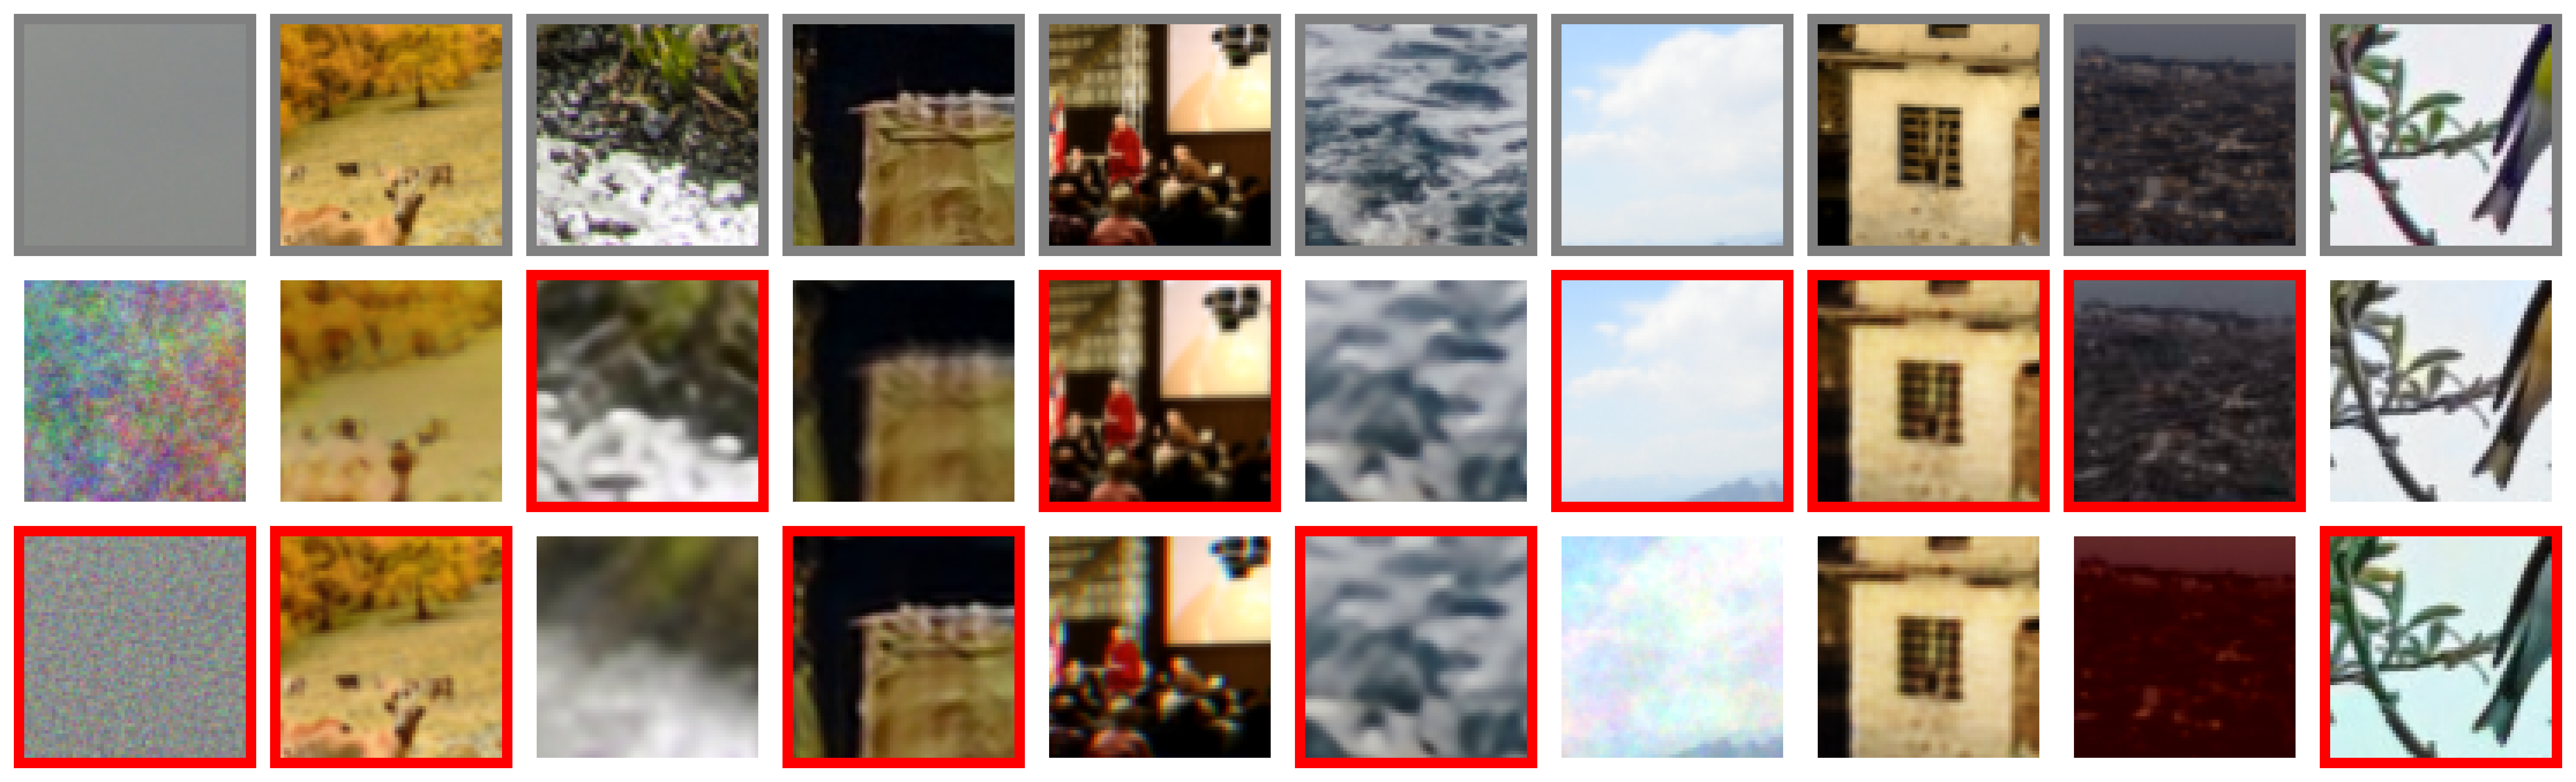

In [20]:
N = len(examples)

ref_list = []
p0_list = []
p1_list = []

for i in examples:
    ref_list.append(frame(refs[[i]], color=[128,128,128]))
    if judges[i] < 0.5:
        p0_list.append(frame(p0s[[i]], color=[255,0,0]))
    else:
        p0_list.append(frame(p0s[[i]], color=[255,255,255]))
    if judges[i] > 0.5:
        p1_list.append(frame(p1s[[i]], color=[255,0,0]))
    else:
        p1_list.append(frame(p1s[[i]], color=[255,255,255]))
    
    
images = torch.cat(ref_list + p0_list + p1_list)

grid = torchvision.utils.make_grid(images, nrow=N, padding=4, pad_value=1)
img = to_img(grid)
img.save('./plots/2afc_example.png')
img